# Bankruptcy Prediction - Accenture

Dataset: https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data

Notes:
 - 'TODO OPTIONS' list a variety of possible techniques to consider, only the options marked with '<----' are implemented
 - Assumptions about the task and requirements are made 


In [1]:
# Import libraries
# Data processing
from imblearn.over_sampling import SMOTE
import numpy as np 
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold

# Classification models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, recall_score, precision_score
from xgboost import XGBClassifier

# Pipeline/hyperparameter sarch
from imblearn.pipeline import Pipeline
# from sklearn.pipeline import Pipeline - does not support sampling yet
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.base import TransformerMixin

# Importing/handling data
import pandas as pd
from scipy.io import arff
from sklearn.model_selection import train_test_split

# Saving models
from joblib import dump, load

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()


In [2]:
# Import data
arff_array = [arff.loadarff('data/' +str(i+1) + 'year.arff')[0] for i in range(5)]
df_array = [pd.DataFrame(arff_elem) for arff_elem in arff_array]
del arff_array
df_array[0].head(3)

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.20055,0.37951,0.39641,2.0472,32.3510,0.38825,0.24976,1.33050,1.1389,0.50494,...,0.12196,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,b'0'
1,0.20912,0.49988,0.47225,1.9447,14.7860,0.00000,0.25834,0.99601,1.6996,0.49788,...,0.12130,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,b'0'
2,0.24866,0.69592,0.26713,1.5548,-1.1523,0.00000,0.30906,0.43695,1.3090,0.30408,...,0.24114,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,b'0'


In [3]:
# Convert target to binary
print(df_array[0].dtypes)
for i in range(5):
    df_array[i]['class'] = df_array[i]['class'].astype(int)

Attr1     float64
Attr2     float64
Attr3     float64
Attr4     float64
Attr5     float64
           ...   
Attr61    float64
Attr62    float64
Attr63    float64
Attr64    float64
class      object
Length: 65, dtype: object


0    6756
1     271
Name: class, dtype: int64
Percent bankrupt: 0.04011249259917111
Attr37    2740
Attr21    1622
Attr27     311
Attr60     135
Attr45     134
Attr24     124
Attr41      84
Attr11      39
dtype: int64


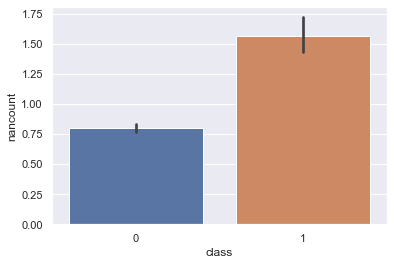

0    9773
1     400
Name: class, dtype: int64
Percent bankrupt: 0.04092909035096695
Attr37    4518
Attr21    3164
Attr27     706
Attr60     543
Attr45     541
Attr24     225
Attr54     212
Attr28     212
dtype: int64


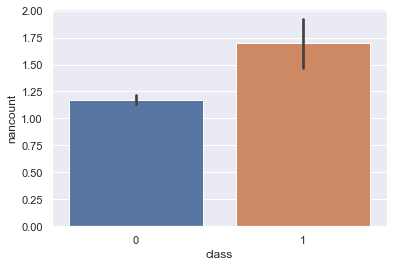

0    10008
1      495
Name: class, dtype: int64
Percent bankrupt: 0.04946043165467626
Attr37    4736
Attr21     807
Attr27     715
Attr60     592
Attr45     591
Attr54     228
Attr64     228
Attr53     228
dtype: int64


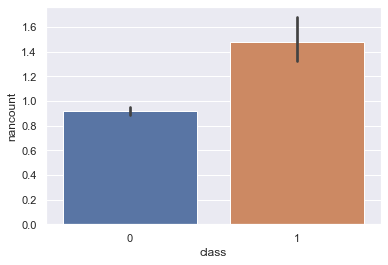

In [4]:
# Analyze data
for i in range(3):
    # Check imbalance 
    value_counts = df_array[i]["class"].value_counts()
    print(value_counts)
    print("Percent bankrupt: " + str(value_counts[1]/value_counts[0]))
    # Missing values - especially: X37, X21 - almost missing 50% of data
    print(df_array[i].isnull().sum().sort_values(ascending=False).head(8))
    # New feature, count missing values in a sample
    df_array[i]["nancount"] = df_array[i].isnull().sum(axis=1)

    # Visualize - bankrupt companies are more likely to have missing data
    ax = sns.barplot(y="nancount", x="class", data=df_array[i])
    plt.savefig(f"plots/classimbalance_year{i}.png", dpi=300)
    plt.show()



In [5]:
## Analyse missing data 
def droppingMissingValues(df_array):    
    df_array_dropped = [df.dropna(axis=0, how='any') for df in df_array]
    for i in range(5):
        percentLost = 1-(len(df_array_dropped[i])/len(df_array[i]))
        print(f"Would drop {percentLost:.0%} in {i+1}year")
    print()

# test amount of rows that would be dropped 
droppingMissingValues(df_array)

# test amount of rows that would be dropped without X37
df_array_droppedX37 = [df_array[i].drop(labels=["Attr37"], axis=1) for i in range(5)]
droppingMissingValues(df_array_droppedX37)

# without X37,X21
df_array_droppedX37X21 = [df_array[i].drop(labels=["Attr37", "Attr21"], axis=1) for i in range(5)]
droppingMissingValues(df_array_droppedX37X21)

# TODO OPTIONS 
# 1. Do missing value imputation on all
# 2. Do missing value imputation on all but Attr37 as it affects between 40%-45% of the data   <----
# -. Removing all is probably not an option as they make up ~55% the dataset
# Additional: analyse correlation of missing values to other features or target 

df_array = df_array_droppedX37
del df_array_droppedX37, df_array_droppedX37X21

Would drop 55% in 1year
Would drop 60% in 2year
Would drop 53% in 3year
Would drop 51% in 4year
Would drop 49% in 5year

Would drop 30% in 1year
Would drop 37% in 2year
Would drop 22% in 3year
Would drop 17% in 4year
Would drop 15% in 5year

Would drop 10% in 1year
Would drop 16% in 2year
Would drop 16% in 3year
Would drop 16% in 4year
Would drop 14% in 5year



In [6]:
# Before pre-processing the data, split it. Additionally, decide if we want to merge datasets:
# TODO OPTIONS - Merging data
# 1. Treating each dataset seperately   <-----
# 2. Treating data as one 
# 3. Combining data successively - e.g. 1st year bankcruptcy is still valid for 2/3/4/5year, 2year bankcruptcy data is also still valid for 3/4/5year etc.

# Lets start with a single year
yearI = 0

df = df_array[yearI].copy()
print(df.columns)

# train test split (will use k-fold cv on train for learning)  
target = df.pop("class")
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.3, random_state=42)


Index(['Attr1', 'Attr2', 'Attr3', 'Attr4', 'Attr5', 'Attr6', 'Attr7', 'Attr8',
       'Attr9', 'Attr10', 'Attr11', 'Attr12', 'Attr13', 'Attr14', 'Attr15',
       'Attr16', 'Attr17', 'Attr18', 'Attr19', 'Attr20', 'Attr21', 'Attr22',
       'Attr23', 'Attr24', 'Attr25', 'Attr26', 'Attr27', 'Attr28', 'Attr29',
       'Attr30', 'Attr31', 'Attr32', 'Attr33', 'Attr34', 'Attr35', 'Attr36',
       'Attr38', 'Attr39', 'Attr40', 'Attr41', 'Attr42', 'Attr43', 'Attr44',
       'Attr45', 'Attr46', 'Attr47', 'Attr48', 'Attr49', 'Attr50', 'Attr51',
       'Attr52', 'Attr53', 'Attr54', 'Attr55', 'Attr56', 'Attr57', 'Attr58',
       'Attr59', 'Attr60', 'Attr61', 'Attr62', 'Attr63', 'Attr64', 'class',
       'nancount'],
      dtype='object')


In [7]:
# Wrapper for sklearn pipeline gridsearchCV
class OperatorSwitcher(BaseEstimator):
    def __init__(self, operator_type: str = 'StandardScaler'):
        """
        operator_type: string - The switch for different estimators
        """
        self.operator_type = operator_type

    def fit(self, X, y=None):
        # Scaling data
        if self.operator_type == 'RobustScaler':
            self.operator_ = RobustScaler()
        elif self.operator_type == 'StandardScaler':
            self.operator_ = StandardScaler()
        # Imputation
        elif self.operator_type == 'KNNImputer':
            self.operator_ = KNNImputer()
        elif self.operator_type == 'SimpleImputer':
            self.operator_ = SimpleImputer(strategy='mean')
        # Classification models 
        elif self.operator_type == 'LogisticRegression':
            self.operator_ = LogisticRegression()
        elif self.operator_type == 'RandomForestClassifier':
            self.operator_ = RandomForestClassifier()
        elif self.operator_type == 'XGBClassifier':
            self.operator_ = XGBClassifier()
        elif self.operator_type == 'SVC':
            self.operator_ = SVC()
        else:
            raise ValueError('Unkown estimator.')

        self.operator_.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.operator_.predict(X)

    def transform(self, X, y=None):
        if self.operator_type in ['LogisticRegression', 'RandomForestClassifier', 'XGBClassifier', 'SVC']:
            return X
        return self.operator_.transform(X)

    def score(self, X, y):
        return self.operator_.score(X, y)


pipeline = Pipeline([
    ('scaler', OperatorSwitcher()),
    ('imputer', OperatorSwitcher()),

    # TODO OPTIONS - Handling imbalance
    # 1. Upsampling - Retaining all information / misclassification of bankcrupt is punished higher, but false negatives are assumed to be most costly, which is good / could lead to overfit
    # 2. Downsampling - loss of information
    # 3. Generating synthetic samples (alternative borderline SMOTE) - SMOTE <----
    # 4. Penalized models, penalty matrix
    ('smt', SMOTE()),

    ('clf', OperatorSwitcher())
])


parameter_space = {
    # Scaling for KNNImputer    
    'scaler__operator_type': ['RobustScaler', 'StandardScaler'], 

    # TODO OPTIONS - Imputation strategy
    # 1. Mean/Average/Zero Imputation <---- 
    # 2. K-Nearest Neighbouts, (using default euclidean distance measure) <---- 
    # 3. Random Forest Imputation - works well on high-dimension
    # 4. ... 
    'imputer__operator_type': ['KNNImputer', 'SimpleImputer'],

    'clf__operator_type': ['LogisticRegression', 'RandomForestClassifier', 'XGBClassifier', 'SVC']
}


# TODO OPTIONS evaluation criteria (depending on goal)
# ASSUMPTION: most important are the true positives, therefore falsely misclassifying a will-be bankrupt company as not bankrupt (false negative) is assumed to be most costly and the worst case
# accuracy - not interesting with class imbalance and interesting class having less samples 
# roc auc - could be an additional insight, but imbalance precision-recall is preffered
# specificity - tn/tp+tn how many predicted non bankrupt companies are really non bankrupt, will be always high in this case, cost of fn is assumed to be low!
# recall/sensitivity - ratio of true positives / tp+fn - how many of the bancrupt did we find? High cost of false negative <---------- most interesting
# precision - ratio of true positives / total predicted positives - out of all predicted as bankcrupt, who are truly!  <------- how high is the cost of false positive?
# f1 harmonic mean of precision and recall, best total under assumptions <-----
# balanced accuracy (as alternative to f1) - would be good if cost of fp and fn are equal, we assume it is not.
evalMetrics = {
    'precision': 'precision', 
    'recall': 'recall', 
    'f1': 'f1', 
    'accuracy': 'accuracy'
}


search = GridSearchCV(pipeline, parameter_space, scoring=evalMetrics, refit='f1', n_jobs=-1, cv=5)
search.fit(X_train, y_train)

print('Best model:\n', search.best_params_)

# pipeline.score(X_test, y_test)
search.cv_results_

# model persistence
dump(search, f' model_year{yearI}.joblib') 

Best model:
 {'clf__operator_type': 'XGBClassifier', 'imputer__operator_type': 'SimpleImputer', 'scaler__operator_type': 'RobustScaler'}


[' model_year0.joblib']

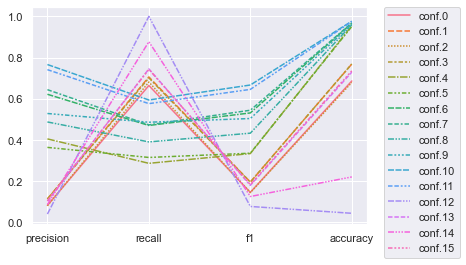

{'clf__operator_type': 'SVC', 'imputer__operator_type': 'KNNImputer', 'scaler__operator_type': 'RobustScaler'}
{'clf__operator_type': 'XGBClassifier', 'imputer__operator_type': 'SimpleImputer', 'scaler__operator_type': 'RobustScaler'}
{'clf__operator_type': 'RandomForestClassifier', 'imputer__operator_type': 'KNNImputer', 'scaler__operator_type': 'StandardScaler'}


In [8]:
# Plot configuration performances
num_configurations = len(search.cv_results_["params"])

index = evalMetrics.values()
values = [search.cv_results_["mean_test_" + str(metric)] for metric in index]
columns = ["conf." + str(i) for i in range(num_configurations)]

plot_df = pd.DataFrame(data=values, index=index, columns=columns)

ax = sns.lineplot(data=plot_df) 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig(f"plots/train_performance_year{yearI}.png", dpi=300)
plt.show()


print(search.cv_results_['params'][np.where(search.cv_results_['rank_test_f1'] == num_configurations)[0][0]])
print(search.cv_results_['params'][np.where(search.cv_results_['rank_test_f1'] == 1)[0][0]])
print(search.cv_results_['params'][np.where(search.cv_results_['rank_test_f1'] == 7)[0][0]])


f1 score: 0.676056338028169
accuracy: 0.9781887150308203
Precision: 0.7164179104477612
recall: 0.64


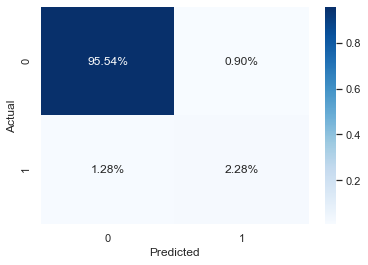

In [9]:
# Printing evaluation metrics
def scores(y_test, y_predictions, benchline=False):
    print("f1 score: " + str(f1_score(y_test,y_predictions)))
    print("accuracy: " + str(accuracy_score(y_test,y_predictions)))
    print("Precision: " + str(precision_score(y_test,y_predictions)))
    print("recall: " + str(recall_score(y_test,y_predictions)))

    # plot confusion matrix
    cf_matrix = confusion_matrix(y_test,y_predictions)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
                fmt='.2%', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    if benchline:
        plt.savefig(f"plots/confusion_year{yearI}_benchline.png", dpi=300)
    else:
        plt.savefig(f"plots/confusion_year{yearI}.png", dpi=300)
    plt.show()


# Testing on final set
y_predictions = search.predict(X_test)
scores(y_test,y_predictions)

f1 score: 0.0
accuracy: 0.992552471225457
Precision: 0.0
recall: 0.0


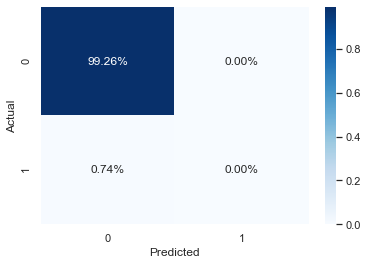

In [10]:
# Producing a benchline with simplest approach
def test_benchline(df):
    df_dropped = df.dropna(axis=0, how='any') 
    target = df_dropped.pop("class")
    X_train, X_test, y_train, y_test = train_test_split(df_dropped, target, test_size=0.3, random_state=42)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)

    scores(y_test,predictions, benchline=True)

test_benchline(df_array[yearI].copy())

## Selection of Important Features


Top 5 feature importance in: [26, 33, 57, 63, 36]


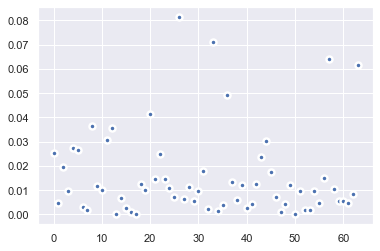

In [11]:
# TODO OPTIONS for feature selection - but considering imbalance
# 1. Embedded, lasso lars, k-best RF, GBM
# 2. Low variance removal - but features with few outliers could be usefull <---
# 3. Correlation (with others and target) (but finds only linear dependencies) <---
# 4. Feature importance of predicting model <----
# 5. Wrapper method - forward, backward, recursive
# 6. FE on data with domain knowledge
# 7. Chi2 - only non negative 

# Selecting features by importance for model
feature_importance = search.best_estimator_.named_steps["clf"].operator_.feature_importances_
feature_importance = list(feature_importance)
# Use only most important features
highest_feature_importance = sorted(range(len(feature_importance)), key=lambda i: feature_importance[i], reverse=True)[:5]
print("Top 5 feature importance in: " + str(highest_feature_importance))

sns.scatterplot(data=feature_importance, palette="tab10", linewidth=2.5)

plt.savefig(f"plots/feature_importance_year{yearI}.png", dpi=300)
plt.show()


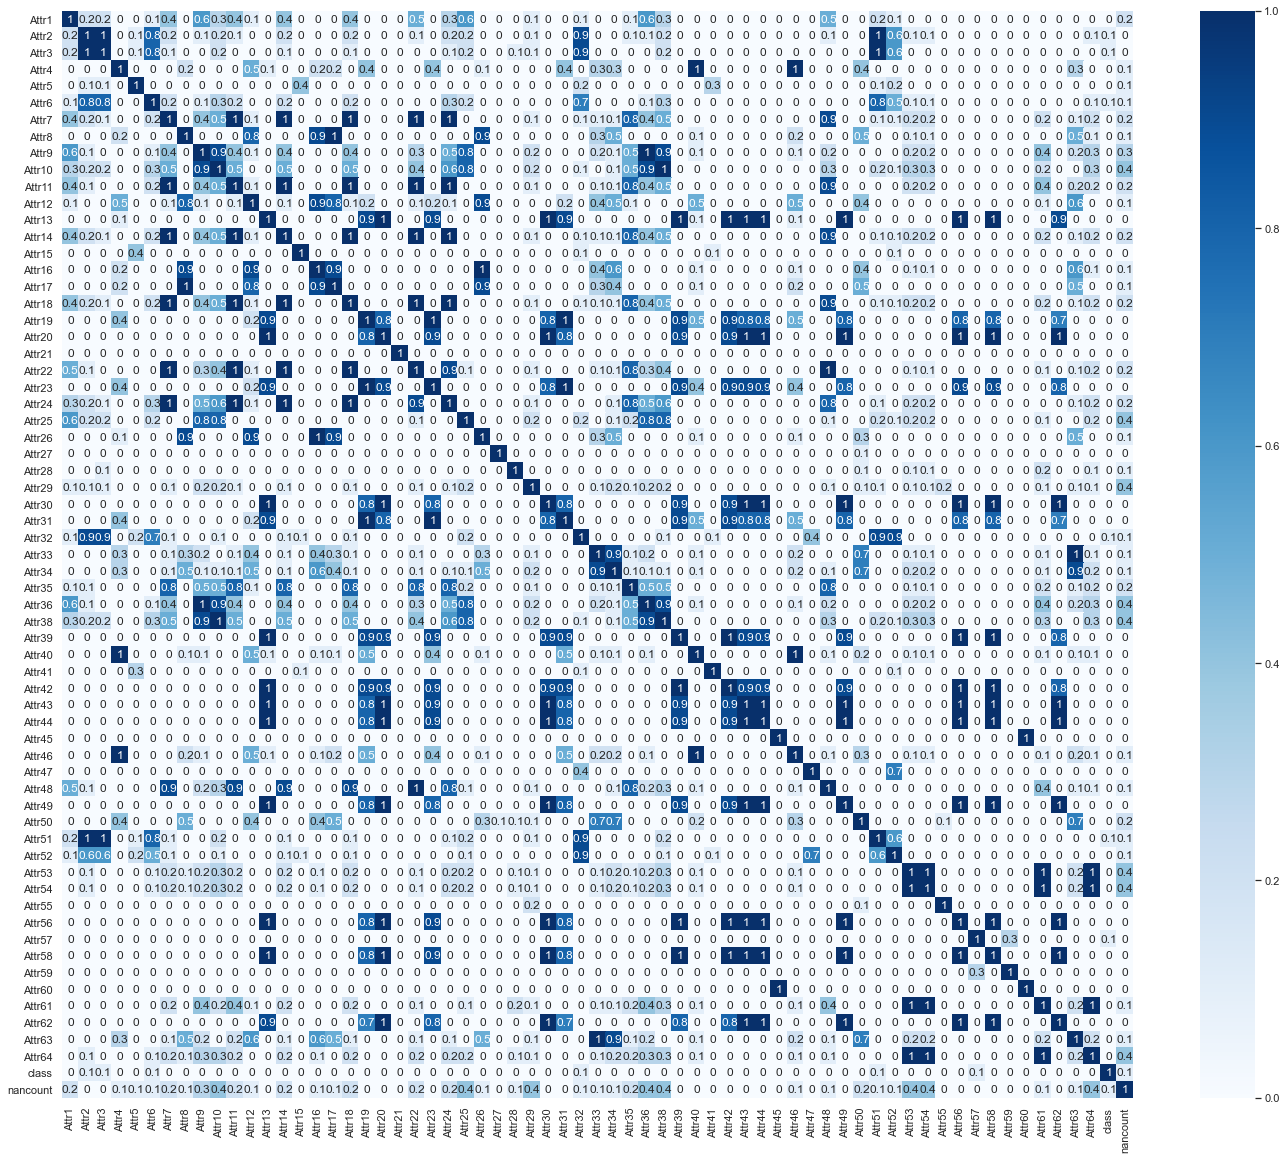

In [12]:
# Correlation of all features and target 
df = df_array[yearI].copy()
df_corr = df.corr().abs().round(1)

plt.figure(figsize=(24,20))
sns.heatmap(df_corr, annot=True, cmap='Blues')
plt.savefig(f"plots/correlation_year{yearI}.png", dpi=300)
plt.show()


In [13]:
## Show amount of features that can be dropped

df_corr = df.corr().abs()

# upper triangle
upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))

def correlation_feature(upper, coefficient):
    # index of feature columns with great correlation 
    redundant_features = [column for column in upper.columns if any(upper[column] >= coefficient)]
    print(redundant_features)
    print("Left with: " + str(64 - len(redundant_features)))

correlation_feature(upper, 0.9)
correlation_feature(upper, 0.95)
correlation_feature(upper, 0.99)

['Attr3', 'Attr10', 'Attr11', 'Attr14', 'Attr16', 'Attr17', 'Attr18', 'Attr20', 'Attr22', 'Attr23', 'Attr24', 'Attr26', 'Attr30', 'Attr31', 'Attr34', 'Attr36', 'Attr38', 'Attr39', 'Attr40', 'Attr42', 'Attr43', 'Attr44', 'Attr46', 'Attr48', 'Attr49', 'Attr51', 'Attr52', 'Attr54', 'Attr56', 'Attr58', 'Attr60', 'Attr61', 'Attr62', 'Attr63', 'Attr64']
Left with: 29
['Attr3', 'Attr11', 'Attr14', 'Attr17', 'Attr18', 'Attr20', 'Attr22', 'Attr23', 'Attr24', 'Attr26', 'Attr30', 'Attr31', 'Attr36', 'Attr38', 'Attr39', 'Attr40', 'Attr42', 'Attr43', 'Attr44', 'Attr46', 'Attr48', 'Attr49', 'Attr51', 'Attr54', 'Attr56', 'Attr58', 'Attr60', 'Attr61', 'Attr62', 'Attr63', 'Attr64']
Left with: 33
['Attr11', 'Attr14', 'Attr17', 'Attr18', 'Attr20', 'Attr23', 'Attr30', 'Attr31', 'Attr36', 'Attr38', 'Attr42', 'Attr43', 'Attr44', 'Attr49', 'Attr51', 'Attr54', 'Attr56', 'Attr58']
Left with: 46


In [14]:
# Correlation with output variable
corr_target = abs(df_corr["class"])
# Selecting highly correlated features
relevant_features = corr_target[corr_target>0.9]
# No correlation with target 
relevant_features

class    1.0
Name: class, dtype: float64

In [15]:
# Test variance of features 
selector = VarianceThreshold(.5 * (1 - .5))
print(selector.fit_transform(X_train).shape)

print(X_train.var())

(4918, 64)
Attr1       2.952332e+01
Attr2       4.085955e+01
Attr3       3.972989e+01
Attr4       2.336837e+02
Attr5       1.724496e+09
                ...     
Attr61      9.761780e+04
Attr62      1.272514e+11
Attr63      4.810159e+02
Attr64      3.576396e+07
nancount    1.756937e+00
Length: 64, dtype: float64


In [16]:
# TODO Further improvements 
# Collect more data of imbalanced class
# Test more options and hyperparameter optimization
# feature engineering - domain knowledge, analyzing deviation in CV